<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [1]:
## Library
import os
from config import constants
from services import file_services
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from services.StockService import StockService

About to make logging dir (if nec): C:\Users\Chris\logs\stock_predictor
Setting up logging...
Creating logger config; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.file_services; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.chart_service; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.spark.spark_split_eod_data; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.split_eod_data_to_files_service; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.eod_data_service; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.RealtimeEquityPriceService; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.EquityUtilService; config.constants.IS_IN_SPARK_CONTEXT: False
Creating logger services.StockService; config.constants.IS_IN_SPARK_CONTEXT: False


## Data Plot

     high     low
0  568.00  552.92
1  566.43  558.67
2  567.00  556.93
3  568.45  558.71
4  604.83  562.19: 2


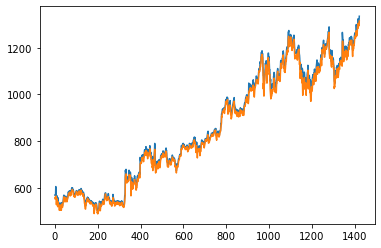

In [2]:
# airline_pass_path = os.path.join(constants.OUTPUT_DIR, 'airline-passengers.csv')
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# file_services.download_file(url, airline_pass_path, False)
# training_set = pd.read_csv(airline_pass_path)

symbol = "GOOG"
training_set = StockService.get_symbol_df(symbol, translate_file_path_to_hdfs=False)

# print(training_set.head())

training_set = training_set.iloc[:,3:5]

training_num_columns = training_set.shape[1]

print(f"{training_set.head()}: {training_num_columns}")

training_set_np = training_set.values

plt.plot(training_set_np, label = 'LSTM')
plt.show()

## Dataloading

In [3]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
#         print(f"_x: {_x.shape[1]}")
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

print(f"Orig: {training_set_np[:5,:]}")
print(f"col 1: {training_set_np[:5,1:2]}")

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set_np)

print(f"Transformed td: {training_data.shape}")

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

print(f"SW: {x.shape}")

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

# print(f"dataX: {dataX}")

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))

# print(f"trainX: {trainX}")

trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Orig: [[568.   552.92]
 [566.43 558.67]
 [567.   556.93]
 [568.45 558.71]
 [604.83 562.19]]
col 1: [[552.92]
 [558.67]
 [556.93]
 [558.71]
 [562.19]]
Transformed td: (1422, 2)
SW: (1417, 4, 2)


## Model

In [4]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
#         print(f"Hidden size: {self.hidden_size}.")
        
        h_out = h_out.view(-1, self.hidden_size)
        
#         print(*h_out.shape)
        
        out = self.fc(h_out)
        
#         print(f"Type: {type(out)}")
        
        return out

## Training

In [5]:
num_epochs = 3500
learning_rate = 0.01

input_size = training_num_columns - 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 2

## Testing for LSTM Dataset

In [ ]:
lstm.eval()

print("About to call lstm...")
train_predict = lstm(dataX)

data_predict = np.copy(train_predict.data.numpy())

print(f"data_predict: {data_predict[:5,:]}")
print(f"data_predict shape: {data_predict.shape}")

dataY_plot = np.copy(dataY.data.numpy())

data_predict_transformed = sc.inverse_transform(data_predict)
dataY_plot_transformed = sc.inverse_transform(dataY_plot)

# print(data_predict[1000])
# print(dataY_plot[1000])

pred = data_predict_transformed[1000:]
dataY = dataY_plot_transformed[1000:]

print(np.mean(pred - dataY))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()